# Deep ensemble for ENSO-forecasting

In this tutorial you learn how to use a neural network model called Deep Ensemble (DE) for the ENSO forecasting. This network architecture was initially developed [Lakshminarayanan et al. (2017)](https://papers.nips.cc/paper/7219-simple-and-scalable-predictive-uncertainty-estimation-using-deep-ensembles.pdf). 

DEs are feed foreword neural networks that predict the mean and the standard deviation of a Gaussian. Hence, their predicion comes with an uncertainty estimation which is a valuable feature for ENSO-forecasting.

## Create a data pipe line

At first, we define a data pipeline. This is in general quite useful to keep your code clean and also to reuse the pipeline for later purpose.

The data pipeline generates returns:

1. The feature array

2. The label array

3. The time  array corresponding to the time of the label

NOTE (again): Lead time is defined as the time that passed between the last observed and the first date of the target season. Hence, negative appear, e.g. if you compare the DJF season with the target season JFM, you have a lead time of -2 month (Last observed date: Feburary 28/29, First date of the target season January 1).

In [15]:
import numpy as np
from sklearn.preprocessing import StandardScaler

from ninolearn.utils import include_time_lag
from ninolearn.IO.read_processed import data_reader

def pipeline(lead_time):
    """
    Data pipeline for the processing of the data before the Deep Ensemble
    is trained.

    :type lead_time: int
    :param lead_time: The lead time in month.

    :returns: The feature "X" (at observation time), the label "y" (at lead
    time), the target season "timey" (least month)
    """
    reader = data_reader(startdate='1980-01', enddate='2018-12')

    # indeces
    oni = reader.read_csv('oni')
    iod = reader.read_csv('iod')
    wwv = reader.read_csv('wwv')

    # seasonal cycle
    sc = np.cos(np.arange(len(oni))/12*2*np.pi)

    # network metrics
    network_ssh = reader.read_statistic('network_metrics', variable='sst', dataset='ERSSTv5', processed="anom")
    c2 = network_ssh['fraction_clusters_size_2']
    H = network_ssh['corrected_hamming_distance']

    # time lag
    time_lag = 12

    # shift such that lead time corresponds to the definition of lead time
    shift = 3

    # process features
    feature_unscaled = np.stack((oni, sc, wwv, iod,
                                 c2, H), axis=1)

    # scale each feature
    scalerX = StandardScaler()
    Xorg = scalerX.fit_transform(feature_unscaled)

    # set nans to 0.
    Xorg = np.nan_to_num(Xorg)

    # arange the feature array
    X = Xorg[:-lead_time-shift,:]
    X = include_time_lag(X, max_lag=time_lag)

    # arange label
    yorg = oni.values
    y = yorg[lead_time + time_lag + shift:]

    # get the time axis of the label
    timey = oni.index[lead_time + time_lag + shift:]

    return X, y, timey

## Split the data set

For the training and testing of machine learning models it is crucial to split the data set into:

1. __Train data set__ which is used to train the weights of the neural network

2. __Validation data set__ which is used to check for overfitting (e.g. when using early stopping) and to optimize the hyperparameters 

3. __Test data set__ which is used to to evaluate the trained model. 

__NOTE:__ It is important to understand that hyperparamters must be tuned so that the result is best for the Validation data set and __not__ for the test data set. Otherwise you can not rule out the case that the specific hyperparameter setting just works good for the specific test data set but is not generally a good hyperparameter setting.

In the following cell the train and the validation data set are still one data set, because this array will be later splitted into two arrays when th model is fitted.

In [16]:
import keras.backend as K
from ninolearn.learn.models.dem import DEM

# clear memory from previous sessions
K.clear_session()

# define the lead time
lead_time = 3

# get the features (X), the label (y) and 
# the time axis of the label (timey)
X, y, timey = pipeline(lead_time)

# split the data set into 
test_indeces = (timey>='2001-01-01') & (timey<='2018-12-01')
train_val_indeces = np.invert(test_indeces)

train_val_X, train_val_y, train_val_timey = X[train_val_indeces,:], y[train_val_indeces], timey[train_val_indeces]
testX, testy, testtimey = X[test_indeces,:], y[test_indeces], timey[test_indeces]

## Fit the model

Now it is time to train the model! For this a random search is used for all keyword arguments that are passed in a *list* to the DEM.set_parameters() method. 

In [17]:
# initiated an instance of the DEM (Deep Ensemble Model) class
model = DEM()

# Set parameters
model.set_hyperparameters(layers=1, neurons=16, dropout=[0.1, 0.5], noise_in=[0.1,0.5], noise_sigma=[0.1,0.5],
                     noise_mu=[0.1,0.5], l1_hidden=[0.0, 0.2], l2_hidden=[0., 0.2],
                     l1_mu=[0.0, 0.2], l2_mu=[0.0, 0.2], l1_sigma=[0.0, 0.2],
                     l2_sigma=[0.0, 0.2], lr=[0.0001,0.01], batch_size=100, epochs=500, n_segments=5,
                     n_members_segment=1, patience=30, verbose=0, pdf='normal')



# Use a random search to find the optimal hyperparamteres
model.fit_RandomizedSearch(train_val_X, train_val_y, n_iter=20)

Search iteration Nr 1/20
Train member Nr 1/5
--------------------------------------
Restoring model weights from the end of the best epoch
Epoch 00052: early stopping
46/46 [==============================] - 0s 84us/step
Train member Nr 2/5
--------------------------------------
Restoring model weights from the end of the best epoch
Epoch 00132: early stopping
46/46 [==============================] - 0s 71us/step
Train member Nr 3/5
--------------------------------------
Restoring model weights from the end of the best epoch
Epoch 00059: early stopping
46/46 [==============================] - 0s 50us/step
Train member Nr 4/5
--------------------------------------
Restoring model weights from the end of the best epoch
Epoch 00031: early stopping
46/46 [==============================] - 0s 50us/step
Train member Nr 5/5
--------------------------------------
Restoring model weights from the end of the best epoch
Epoch 00096: early stopping
46/46 [==============================] - 0s 46us/

46/46 [==============================] - 0s 52us/step
Train member Nr 2/5
--------------------------------------
Restoring model weights from the end of the best epoch
Epoch 00048: early stopping
46/46 [==============================] - 0s 49us/step
Train member Nr 3/5
--------------------------------------
Restoring model weights from the end of the best epoch
Epoch 00031: early stopping
46/46 [==============================] - 0s 109us/step
Train member Nr 4/5
--------------------------------------
Restoring model weights from the end of the best epoch
Epoch 00031: early stopping
46/46 [==============================] - 0s 68us/step
Train member Nr 5/5
--------------------------------------
Restoring model weights from the end of the best epoch
Epoch 00031: early stopping
46/46 [==============================] - 0s 46us/step
Loss: 0.5316211005915765
Computation time: 9.0s
Search iteration Nr 8/20
Train member Nr 1/5
--------------------------------------
46/46 [======================

Train member Nr 1/5
--------------------------------------
Restoring model weights from the end of the best epoch
Epoch 00107: early stopping
46/46 [==============================] - 0s 96us/step
Train member Nr 2/5
--------------------------------------
Restoring model weights from the end of the best epoch
Epoch 00031: early stopping
46/46 [==============================] - 0s 54us/step
Train member Nr 3/5
--------------------------------------
Restoring model weights from the end of the best epoch
Epoch 00058: early stopping
46/46 [==============================] - 0s 168us/step
Train member Nr 4/5
--------------------------------------
Restoring model weights from the end of the best epoch
Epoch 00031: early stopping
46/46 [==============================] - 0s 73us/step
Train member Nr 5/5
--------------------------------------
Restoring model weights from the end of the best epoch
Epoch 00032: early stopping
46/46 [==============================] - 0s 123us/step
Loss: 0.5440963976

Restoring model weights from the end of the best epoch
Epoch 00160: early stopping
46/46 [==============================] - 0s 306us/step
Train member Nr 3/5
--------------------------------------
Restoring model weights from the end of the best epoch
Epoch 00061: early stopping
46/46 [==============================] - 0s 276us/step
Train member Nr 4/5
--------------------------------------
Restoring model weights from the end of the best epoch
Epoch 00031: early stopping
46/46 [==============================] - 0s 191us/step
Train member Nr 5/5
--------------------------------------
Restoring model weights from the end of the best epoch
Epoch 00047: early stopping
46/46 [==============================] - 0s 178us/step
Loss: 0.3001609052652898
Computation time: 21.4s
best loss search: 0.22250935001217803
loss refitting : 0.3001609052652898


## Make predictions for the test data set
Now we can use the trained models to make predicitons on the test data set to evaluate how good the model perfoms on a data set that it never saw before.

In [18]:
pred_mean, pred_std = model.predict(testX)

## Plot the prediction
Let's see how the predicion is looking like

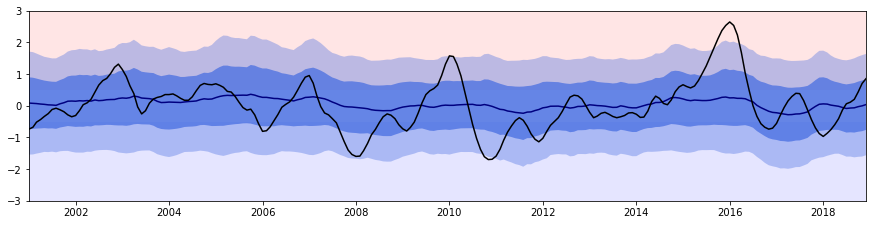

In [20]:
import matplotlib.pyplot as plt
from ninolearn.plot.prediction import plot_prediction
import pandas as pd

plt.subplots(figsize=(15,3.5))
plt.axhspan(-0.5,
            -6,
            facecolor='blue',
            alpha=0.1,zorder=0)

plt.axhspan(0.5,
            6,
            facecolor='red',
            alpha=0.1,zorder=0)

plt.xlim(testtimey[0], testtimey[-1])
plt.ylim(-3,3)

# plot the prediction
plot_prediction(testtimey, pred_mean, std=pred_std, facecolor='royalblue', line_color='navy')

# plot the observation
plt.plot(timey, y, "k")

plt.show()

## Evaluate the model

We can evaluate the model a bit more quantitatively using the loss function that was used to train the model, namely the negative-log-likelihood of the Gaussian and the correlation between the predicted mean and the observed ONI index.

Loss (Negative-Log-Likelihood): 0.19635278216131088


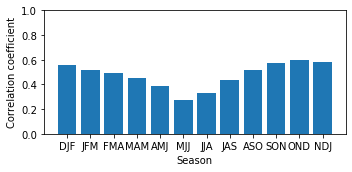

In [21]:
from ninolearn.plot.evaluation import plot_correlation

loss = model.evaluate(testy, pred_mean, pred_std)
print(f"Loss (Negative-Log-Likelihood): {loss}")

# make a plot of the seasonal correaltion
# note: - pd.tseries.offsets.MonthBegin(1) appears to ensure that the correlations are plotted
# agains the correct season
plot_correlation(testy, pred_mean, testtimey - pd.tseries.offsets.MonthBegin(1), title="")